In [29]:
import os

import pandas as pd
import numpy
import matplotlib.pyplot as plt
import math
import cv2
from PIL import Image

In [5]:
PATH_DATA = "data/stanford-car-dataset-by-classes-folder"

In [142]:
labels = ["filename", 'bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'class_id']

def load_meta_data(filename : str, relative_path : str, category : str) -> pd.DataFrame:
    df = pd.read_csv(os.path.join(PATH_DATA, filename))
    df.columns = labels
    df["base_path"] = os.path.abspath(os.path.join(PATH_DATA, relative_path))
    df["category"] = category
    return df

df_train = load_meta_data("anno_train.csv", "car_data/car_data/train", "train")
df_test = load_meta_data("anno_test.csv", "car_data/car_data/test", "test")

df = pd.concat([df_train, df_test])
df

,filename,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class_id,base_path,category
0,00002.jpg,36,116,868,587,3,/home/onyxia/work/army/data/stanford-car-datas...,train
1,00003.jpg,85,109,601,381,91,/home/onyxia/work/army/data/stanford-car-datas...,train
2,00004.jpg,621,393,1484,1096,134,/home/onyxia/work/army/data/stanford-car-datas...,train
3,00005.jpg,14,36,133,99,106,/home/onyxia/work/army/data/stanford-car-datas...,train
4,00006.jpg,259,289,515,416,123,/home/onyxia/work/army/data/stanford-car-datas...,train
...,...,...,...,...,...,...,...,...
8035,08037.jpg,49,57,1169,669,63,/home/onyxia/work/army/data/stanford-car-datas...,test
8036,08038.jpg,23,18,640,459,16,/home/onyxia/work/army/data/stanford-car-datas...,test
8037,08039.jpg,33,27,602,252,17,/home/onyxia/work/army/data/stanford-car-datas...,test
8038,08040.jpg,33,142,521,376,38,/home/onyxia/work/army/data/stanford-car-datas...,test


In [51]:
classes = pd.read_csv(os.path.join(PATH_DATA, "names.csv"))

# put the column as the first row
classes.loc[-1] = classes.columns[0]
classes.index = classes.index + 1
classes = classes.sort_index()

# give the first column a name
classes.columns = ["class_name"]

# add class_id based on indexes
classes.reset_index(inplace=True)
classes.rename(columns={"index": "class_id"}, inplace=True)
classes["class_id"] += 1

classes

,class_id,class_name
0,1,AM General Hummer SUV 2000
1,2,Acura RL Sedan 2012
2,3,Acura TL Sedan 2012
3,4,Acura TL Type-S 2008
4,5,Acura TSX Sedan 2012
...,...,...
191,192,Volkswagen Beetle Hatchback 2012
192,193,Volvo C30 Hatchback 2012
193,194,Volvo 240 Sedan 1993
194,195,Volvo XC90 SUV 2007


In [143]:
if not "class_name" in df.columns:
    df = pd.merge(df, classes, how="left", on=["class_id"])
df

,filename,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class_id,base_path,category,class_name
0,00002.jpg,36,116,868,587,3,/home/onyxia/work/army/data/stanford-car-datas...,train,Acura TL Sedan 2012
1,00003.jpg,85,109,601,381,91,/home/onyxia/work/army/data/stanford-car-datas...,train,Dodge Dakota Club Cab 2007
2,00004.jpg,621,393,1484,1096,134,/home/onyxia/work/army/data/stanford-car-datas...,train,Hyundai Sonata Hybrid Sedan 2012
3,00005.jpg,14,36,133,99,106,/home/onyxia/work/army/data/stanford-car-datas...,train,Ford F-450 Super Duty Crew Cab 2012
4,00006.jpg,259,289,515,416,123,/home/onyxia/work/army/data/stanford-car-datas...,train,Geo Metro Convertible 1993
...,...,...,...,...,...,...,...,...,...
16178,08037.jpg,49,57,1169,669,63,/home/onyxia/work/army/data/stanford-car-datas...,test,Chevrolet Sonic Sedan 2012
16179,08038.jpg,23,18,640,459,16,/home/onyxia/work/army/data/stanford-car-datas...,test,Audi V8 Sedan 1994
16180,08039.jpg,33,27,602,252,17,/home/onyxia/work/army/data/stanford-car-datas...,test,Audi 100 Sedan 1994
16181,08040.jpg,33,142,521,376,38,/home/onyxia/work/army/data/stanford-car-datas...,test,BMW Z4 Convertible 2012


In [144]:
if not "path" in df.columns:
    df["path"] = df.base_path + "/" + df.class_name + "/" + df.filename
    df.drop(columns=["base_path", "filename"], inplace=True)
df.path.iloc[0]

'/home/onyxia/work/army/data/stanford-car-dataset-by-classes-folder/car_data/car_data/train/Acura TL Sedan 2012/00002.jpg'

### Class repartition

In [26]:
df2 = df.groupby(by="class_name").aggregate({"class_name": "count"}).rename(columns={"class_name": "count"}).reset_index()
df2["year"] = df2["class_name"].astype(str).str.slice(-5)
df2["model"] = df2["class_name"].str.split(" ").str[0]
print("Nb basic model (fisrt name (e.g. Acura)):", df2["model"].unique().size)
df2

Nb basic model (fisrt name (e.g. Acura)): 49


,class_name,count,year,model
0,AM General Hummer SUV 2000,89,2000,AM
1,Acura Integra Type R 2001,89,2001,Acura
2,Acura RL Sedan 2012,64,2012,Acura
3,Acura TL Sedan 2012,86,2012,Acura
4,Acura TL Type-S 2008,84,2008,Acura
...,...,...,...,...
191,Volkswagen Golf Hatchback 2012,86,2012,Volkswagen
192,Volvo 240 Sedan 1993,91,1993,Volvo
193,Volvo C30 Hatchback 2012,83,2012,Volvo
194,Volvo XC90 SUV 2007,86,2007,Volvo


22


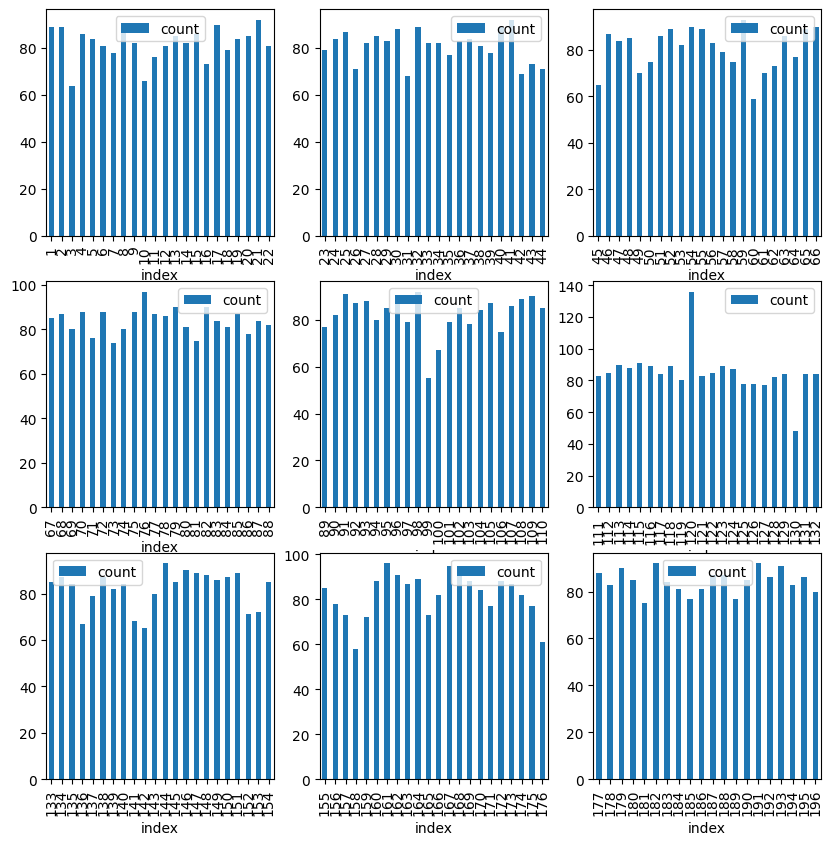

In [69]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))

val = math.ceil(df2.shape[0] / 9)
print(val)
for k in range(9):
    b = k * val
    u = min((k + 1) * val, df2.shape[0])

    # move the index to one
    df21 = df2[["count"]].iloc[b:u]
    df21["index"] = df21.index + 1
    df21.set_index("index", inplace=True)
    
    df21.plot(ax=axes[k // 3][k % 3], kind="bar")


<Axes: xlabel='year'>

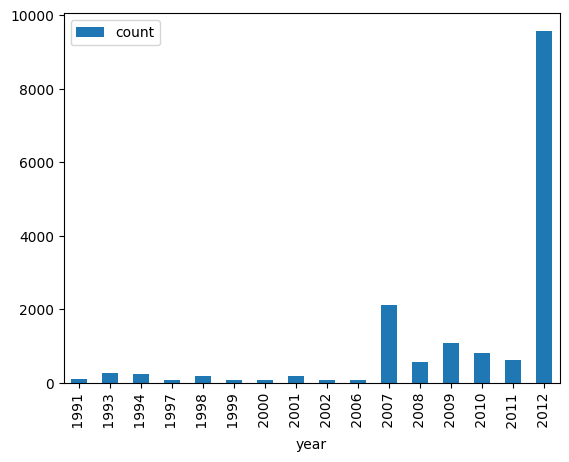

In [27]:
df2.groupby("year").aggregate({"count": "sum"}).plot(kind="bar")

<Axes: xlabel='model'>

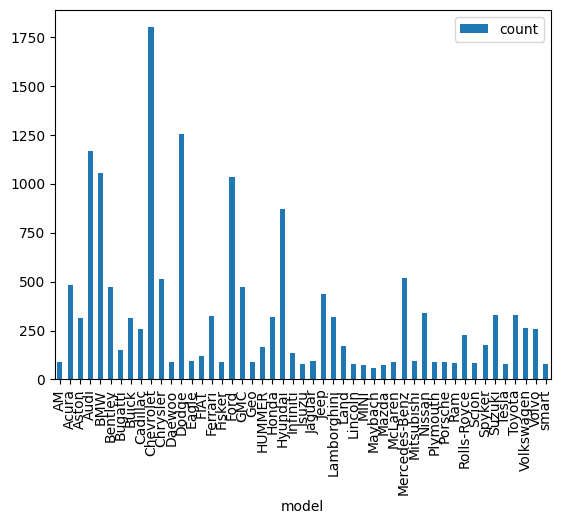

In [110]:
df2.groupby("model").aggregate({"count": "sum"}).plot(kind="bar")

### Analyse of image and car sizes

In [145]:
df3 = df.iloc[:].copy()
def func(x):
    im = cv2.imread(x)
    return im.shape[:2]
df3["shape"] = df3["path"].apply(func)
df3["height_image"] = df3["shape"].str[0]
df3["width_image"] = df3["shape"].str[1]
df3["width_car"] = df3["bbox_x2"] - df3["bbox_x1"]
df3["height_car"] = df3["bbox_y2"] - df3["bbox_y1"]
df3

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class_id,category,class_name,path,shape,height_image,width_image,width_car,height_car
0,36,116,868,587,3,train,Acura TL Sedan 2012,/home/onyxia/work/army/data/stanford-car-datas...,"(675, 900)",675,900,832,471
1,85,109,601,381,91,train,Dodge Dakota Club Cab 2007,/home/onyxia/work/army/data/stanford-car-datas...,"(480, 640)",480,640,516,272
2,621,393,1484,1096,134,train,Hyundai Sonata Hybrid Sedan 2012,/home/onyxia/work/army/data/stanford-car-datas...,"(1386, 2100)",1386,2100,863,703
3,14,36,133,99,106,train,Ford F-450 Super Duty Crew Cab 2012,/home/onyxia/work/army/data/stanford-car-datas...,"(108, 144)",108,144,119,63
4,259,289,515,416,123,train,Geo Metro Convertible 1993,/home/onyxia/work/army/data/stanford-car-datas...,"(431, 575)",431,575,256,127
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16178,49,57,1169,669,63,test,Chevrolet Sonic Sedan 2012,/home/onyxia/work/army/data/stanford-car-datas...,"(800, 1200)",800,1200,1120,612
16179,23,18,640,459,16,test,Audi V8 Sedan 1994,/home/onyxia/work/army/data/stanford-car-datas...,"(480, 640)",480,640,617,441
16180,33,27,602,252,17,test,Audi 100 Sedan 1994,/home/onyxia/work/army/data/stanford-car-datas...,"(303, 635)",303,635,569,225
16181,33,142,521,376,38,test,BMW Z4 Convertible 2012,/home/onyxia/work/army/data/stanford-car-datas...,"(427, 640)",427,640,488,234


##### Image size

<Axes: xlabel='width_image', ylabel='height_image'>

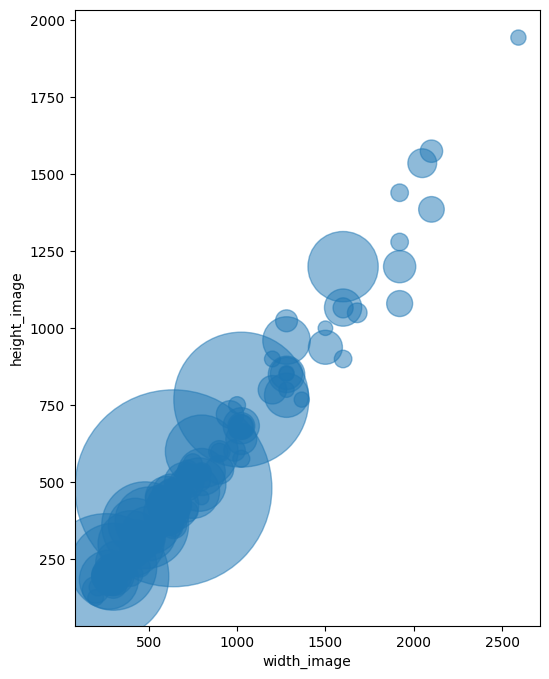

In [146]:
# Calculate the count of samples for each combination of width and height
df31 = df3.groupby(['width_image', 'height_image']).size().reset_index(name='count')
df31 = df31[df31["count"] > 10]

# Plot scatter plot directly from DataFrame
df31.plot(kind='scatter', x='width_image', y='height_image', s=df31['count'] * 10, alpha=0.5, figsize=(6, 8))

In [147]:
pd.DataFrame([
    df3.width_image.agg(["mean", "std", "min", "max"]),
    df3.height_image.agg(["mean", "std", "min", "max"]),
])

,mean,std,min,max
width_image,700.513131,453.25475,78.0,7800.0
height_image,483.281468,318.32877,41.0,5400.0


##### Compare image size to car image

In [148]:
df32 = df3[["width_car", "height_car", "width_image", "height_image", "path"]].copy()
df32["width_per"] = df32.width_car / df32.width_image * 100
df32["height_per"] = df32.height_car / df32.height_image * 100
df32

,width_car,height_car,width_image,height_image,path,width_per,height_per
0,832,471,900,675,/home/onyxia/work/army/data/stanford-car-datas...,92.444444,69.777778
1,516,272,640,480,/home/onyxia/work/army/data/stanford-car-datas...,80.625000,56.666667
2,863,703,2100,1386,/home/onyxia/work/army/data/stanford-car-datas...,41.095238,50.721501
3,119,63,144,108,/home/onyxia/work/army/data/stanford-car-datas...,82.638889,58.333333
4,256,127,575,431,/home/onyxia/work/army/data/stanford-car-datas...,44.521739,29.466357
...,...,...,...,...,...,...,...
16178,1120,612,1200,800,/home/onyxia/work/army/data/stanford-car-datas...,93.333333,76.500000
16179,617,441,640,480,/home/onyxia/work/army/data/stanford-car-datas...,96.406250,91.875000
16180,569,225,635,303,/home/onyxia/work/army/data/stanford-car-datas...,89.606299,74.257426
16181,488,234,640,427,/home/onyxia/work/army/data/stanford-car-datas...,76.250000,54.800937


In [158]:
def round_n(serie : pd.Series, n : int = 4):
    return (serie // n) * n + n * (serie % n > n / 2)
df32["width_per"] = round_n(df32["width_per"])
df32["height_per"] = round_n(df32["height_per"])
df32

,width_car,height_car,width_image,height_image,path,width_per,height_per
0,832,471,900,675,/home/onyxia/work/army/data/stanford-car-datas...,88.0,68.0
1,516,272,640,480,/home/onyxia/work/army/data/stanford-car-datas...,80.0,52.0
2,863,703,2100,1386,/home/onyxia/work/army/data/stanford-car-datas...,40.0,52.0
3,119,63,144,108,/home/onyxia/work/army/data/stanford-car-datas...,84.0,60.0
4,256,127,575,431,/home/onyxia/work/army/data/stanford-car-datas...,44.0,28.0
...,...,...,...,...,...,...,...
16178,1120,612,1200,800,/home/onyxia/work/army/data/stanford-car-datas...,88.0,76.0
16179,617,441,640,480,/home/onyxia/work/army/data/stanford-car-datas...,96.0,88.0
16180,569,225,635,303,/home/onyxia/work/army/data/stanford-car-datas...,88.0,76.0
16181,488,234,640,427,/home/onyxia/work/army/data/stanford-car-datas...,76.0,52.0


<Axes: xlabel='width_per', ylabel='height_per'>

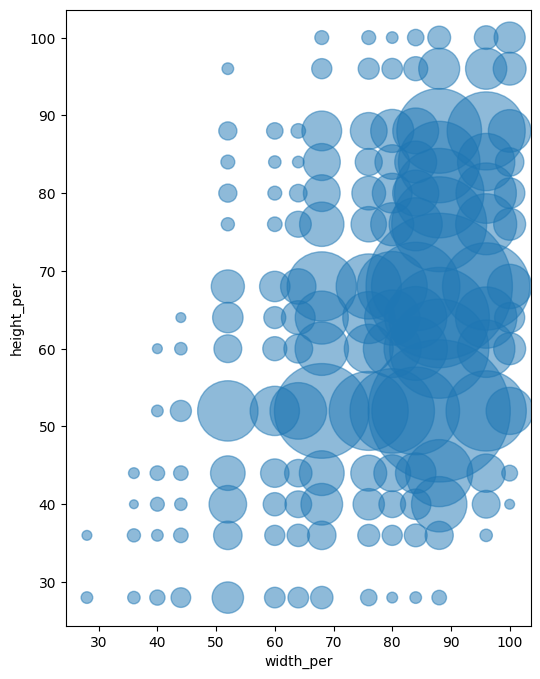

In [161]:
# Calculate the count of samples for each combination of width and height
df33 = df32.groupby(['width_per', 'height_per']).size().reset_index(name='count')
df33 = df33[df33["count"] > 3]

# Plot scatter plot directly from DataFrame
df33.plot(kind='scatter', x='width_per', y='height_per', s=df33['count'] * 10, alpha=0.5, figsize=(6, 8))

In [162]:
print(f"'{df32[df32.width_per > 100].path.iloc[0]}'")
df32[df32.width_per > 100]

'/home/onyxia/work/army/data/stanford-car-dataset-by-classes-folder/car_data/car_data/train/BMW X5 SUV 2007/07389.jpg'


,width_car,height_car,width_image,height_image,path,width_per,height_per
7387,661,430,576,768,/home/onyxia/work/army/data/stanford-car-datas...,112.0,52.0


In [164]:
pd.DataFrame([
    df32.width_per.agg(["mean", "std", "min", "max"]),
    df32.height_per.agg(["mean", "std", "min", "max"]),
])

,mean,std,min,max
width_per,82.001359,12.527355,16.0,112.0
height_per,64.468146,15.273855,20.0,100.0
